In [1]:
"""
Optuna example that optimizes a Keras model
"""
import optuna
from optuna.integration.mlflow import MLflowCallback
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import utils, regularizers
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


print(f"TensorFlow {tf.__version__}")
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print(f"Number of available GPUs : {len(gpus)}")
    tf.config.set_visible_devices(gpus[0],"GPU")
    tf.config.experimental.set_memory_growth(gpus[0],True)
else:
    print("No GPU available, using CPU !!!")    

# To disable GPU use
tf.config.set_visible_devices([], 'GPU')
print("Not using GPU !!!")    


NCONSTIT=16
NFEAT=3
NTRIALS = 100
MTR='val_categorical_accuracy'
NEPOCHS = 100
BSIZES = [32,64,128]  # batch size for Optuna search
#BSIZES = [16,32,64]  # batch size for Optuna search
MINLR = 0.0001
MAXLR = 0.0005
MAXNL = 8 # maximum number of layer for Optuna search
MINNEU = 8 # minimum number of neurons per layer for Optuna search
MAXNEU = 96   # maximum number of neurons per layer for Optuna search
PATIEN = 20 # maximum pacience for early stop and checkpoint
REGL1 = 0.0001

# OPTUNA trial syntax
# filters=trial.suggest_categorical("filters", [32, 64]),
# activation=trial.suggest_categorical("activation", ["relu", "linear"]),
# learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
# num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 128, log=True)            
            

def create_model(trial):
    model = Sequential()

    # Define the MLP.
    nlayers = trial.suggest_int("nlayers", 1, MAXNL)
    model = Sequential()
    model.add(Input(shape=(NCONSTIT*NFEAT)))
    for i in range(nlayers):
        nhidden = trial.suggest_int("nhidden_l{}".format(i), MINNEU, MAXNEU, log=True)
        model.add( Dense(nhidden, name=f'Dense_{i}' ,activation="relu" , kernel_regularizer=regularizers.L1(REGL1), bias_regularizer=regularizers.L1(REGL1) ) )
    model.add( Dense(5, name=f'Dense_{nlayers}'  , activation="softmax", kernel_regularizer=regularizers.L1(REGL1), bias_regularizer=regularizers.L1(REGL1) ) )

    
    # Define the optimizer
    optim = Adam( learning_rate= trial.suggest_float("learning_rate", MINLR, MAXLR, log=True) )

# compile the model
    model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy','categorical_accuracy'])
    model.summary(expand_nested=True)
    return model


def objective(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()
    
    # early stopping callback
    es = EarlyStopping(monitor=MTR, patience=PATIEN)

    # Learning rate scheduler 
    ls = ReduceLROnPlateau(monitor=MTR, factor=0.8, patience=PATIEN, min_lr=0.00001)


    # model checkpoint callback to save best model architecture + parameters into bestmodel.h5
    chkp = ModelCheckpoint('bestmodel.h5', monitor=MTR, verbose=0, save_best_only=True, mode='auto', save_freq='epoch')

    # Optuna pruner callback to drop non promising trials 
    # BE CAREFULL as this might bias towards faster learning models with lower performance at the end of traing !!!
    pru = optuna.integration.TFKerasPruningCallback(trial, monitor=MTR)


    # Create the model
    model = create_model(trial)

    # Fit the model
    history = model.fit(X_train, Y_train, 
              batch_size= trial.suggest_categorical("bsize", BSIZES),  
              epochs=NEPOCHS, 
              verbose=0,
#              validation_data=(X_val, Y_val),
              validation_split=0.2,
              callbacks=[es,ls,chkp,pru],
#              callbacks=[es,ls,chkp],
              shuffle=True,
              )

    # Load the best saved model
    model = tf.keras.models.load_model( 'bestmodel.h5',)
    
#                                         custom_objects={ "QDense": QDense,"QActivation": QActivation,
#                                                          "QConv1D": QConv1D, "quantized_bits": quantized_bits,
#                                                          "NodeEdgeProjection": NodeEdgeProjection,} )                                        

    # Plot Loss and Accuracy versus Epoch
    
    plt.figure(figsize=(15,10))
    ax = plt.subplot(2, 2, 1)
    ax.plot(history.history['loss'], label='loss')
    ax.plot(history.history['val_loss'], label='val loss')
    ax.legend(loc="upper right")
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

    # Plot training accuracy vs epoch
    ax = plt.subplot(2, 2, 2)
    #ax.plot(history.history['accuracy'], label='accuracy')
    #ax.plot(history.history['val_accuracy'], label='val accuracy')
    ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
    ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
    ax.legend(loc="upper left")
    ax.set_xlabel('epoch')
    ax.set_ylabel('acc')

    # Display plots
    fig = plt.gcf()
    plt.show()
#    fig.savefig(fname+'.pdf')
    
    # Evaluate the model on the test data and return accuracy for Optuna optimization
    '''
    score = model.evaluate(X_test, Y_test, verbose=2, return_dict=True, batch_size=1)
    print("Score Keys") 
    score.keys
    tf.print(score)
    return score['categorical_accuracy'] # return the model validation accuracy
    '''
    
    Y_pred = model.predict(X_test)
    accuracy = tf.keras.metrics.CategoricalAccuracy()
    accuracy.update_state(Y_test, Y_pred)
    return accuracy.result().numpy()   
    



TensorFlow 2.8.0
Number of available GPUs : 1
Not using GPU !!!



GPU: METAL
Activating procedural GPU memory growth...
kfold numbet of folds: 5
val fold num: 4

----------------
Data loading complete:
File name: None
Training data size: 480,840
Test data size: 120,210
Number of constituents: 16
Number of features: 3
----------------

(480840, 16, 3)
(480840, 48) (120210, 48) (480840, 5) (120210, 5)


[I 2023-11-18 06:02:05,695] A new study created in RDB with name: mlp_study


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 10)                490       
                                                                 
 Dense_1 (Dense)             (None, 5)                 55        
                                                                 
Total params: 545
Trainable params: 545
Non-trainable params: 0
_________________________________________________________________


2023-11-18 06:02:05.889595: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


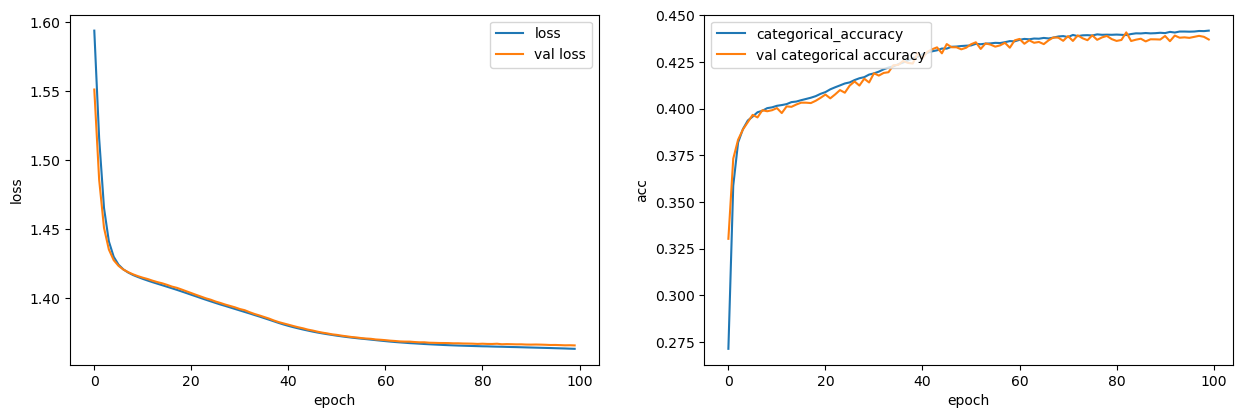

[I 2023-11-18 06:03:53,506] Trial 0 finished with value: 0.43824973702430725 and parameters: {'nlayers': 1, 'nhidden_l0': 10, 'learning_rate': 0.00013943724947200372, 'bsize': 128}. Best is trial 0 with value: 0.43824973702430725.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 38)                1862      
                                                                 
 Dense_1 (Dense)             (None, 5)                 195       
                                                                 
Total params: 2,057
Trainable params: 2,057
Non-trainable params: 0
_________________________________________________________________


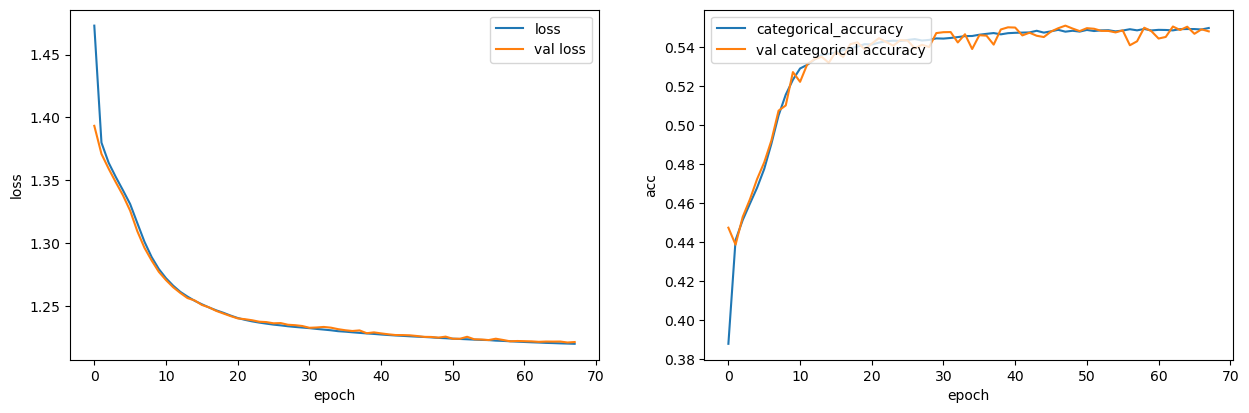

[I 2023-11-18 06:08:33,847] Trial 1 finished with value: 0.5495216846466064 and parameters: {'nlayers': 1, 'nhidden_l0': 38, 'learning_rate': 0.00022136894334015298, 'bsize': 32}. Best is trial 1 with value: 0.5495216846466064.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 48)                2352      
                                                                 
 Dense_1 (Dense)             (None, 9)                 441       
                                                                 
 Dense_2 (Dense)             (None, 29)                290       
                                                                 
 Dense_3 (Dense)             (None, 32)                960       
                                                                 
 Dense_4 (Dense)             (None, 50)                1650      
                                                                 
 Dense_5 (Dense)             (None, 91)                4641      
                                                                 
 Dense_6 (Dense)             (None, 39)               

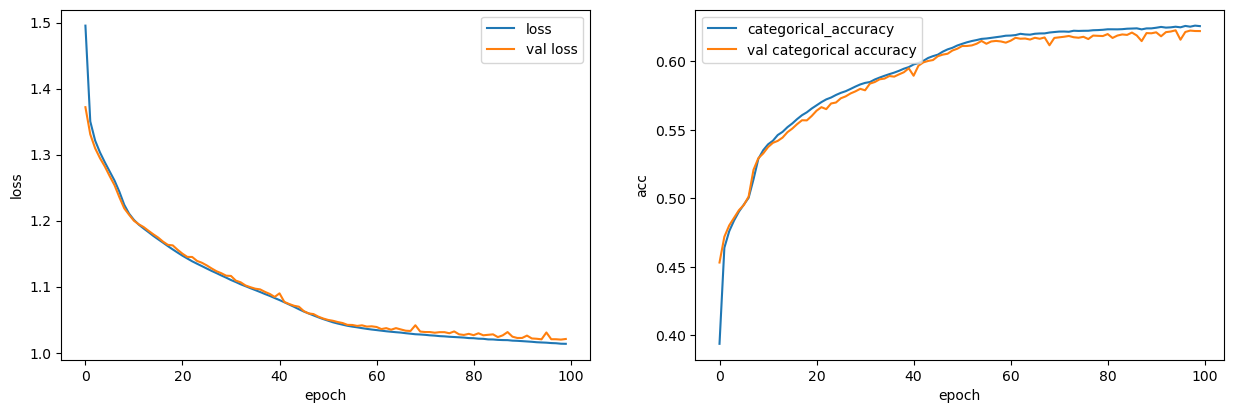

[I 2023-11-18 06:13:03,425] Trial 2 finished with value: 0.6206222176551819 and parameters: {'nlayers': 7, 'nhidden_l0': 48, 'nhidden_l1': 9, 'nhidden_l2': 29, 'nhidden_l3': 32, 'nhidden_l4': 50, 'nhidden_l5': 91, 'nhidden_l6': 39, 'learning_rate': 0.00013294772278008281, 'bsize': 128}. Best is trial 2 with value: 0.6206222176551819.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 56)                2744      
                                                                 
 Dense_1 (Dense)             (None, 43)                2451      
                                                                 
 Dense_2 (Dense)             (None, 70)                3080      
                                                                 
 Dense_3 (Dense)             (None, 44)                3124      
                                                                 
 Dense_4 (Dense)             (None, 5)                 225       
                                                                 
Total params: 11,624
Trainable params: 11,624
Non-trainable params: 0
_________________________________________________________________


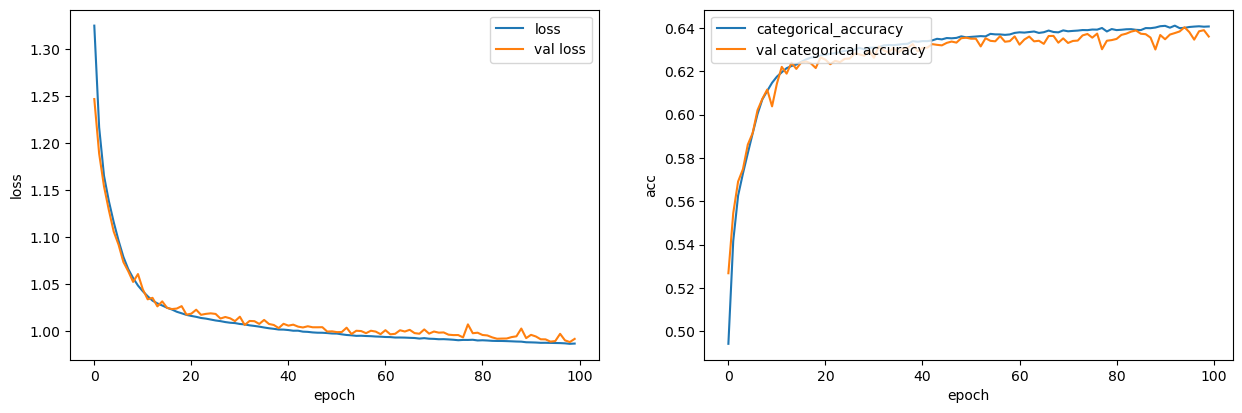

[I 2023-11-18 06:23:01,230] Trial 3 finished with value: 0.6387072801589966 and parameters: {'nlayers': 4, 'nhidden_l0': 56, 'nhidden_l1': 43, 'nhidden_l2': 70, 'nhidden_l3': 44, 'learning_rate': 0.0003466684592364393, 'bsize': 32}. Best is trial 3 with value: 0.6387072801589966.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 46)                2254      
                                                                 
 Dense_1 (Dense)             (None, 10)                470       
                                                                 
 Dense_2 (Dense)             (None, 57)                627       
                                                                 
 Dense_3 (Dense)             (None, 45)                2610      
                                                                 
 Dense_4 (Dense)             (None, 32)                1472      
                                                                 
 Dense_5 (Dense)             (None, 5)                 165       
                                                                 
Total params: 7,598
Trainable params: 7,598
Non-traina

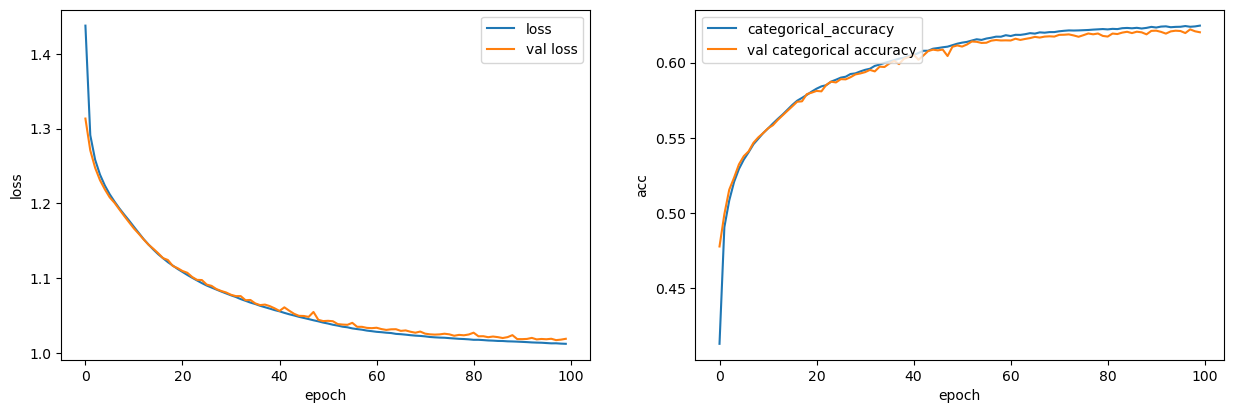

[I 2023-11-18 06:26:15,508] Trial 4 finished with value: 0.6220613718032837 and parameters: {'nlayers': 5, 'nhidden_l0': 46, 'nhidden_l1': 10, 'nhidden_l2': 57, 'nhidden_l3': 45, 'nhidden_l4': 32, 'learning_rate': 0.0001517445407715367, 'bsize': 128}. Best is trial 3 with value: 0.6387072801589966.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 11)                539       
                                                                 
 Dense_1 (Dense)             (None, 18)                216       
                                                                 
 Dense_2 (Dense)             (None, 5)                 95        
                                                                 
Total params: 850
Trainable params: 850
Non-trainable params: 0
_________________________________________________________________


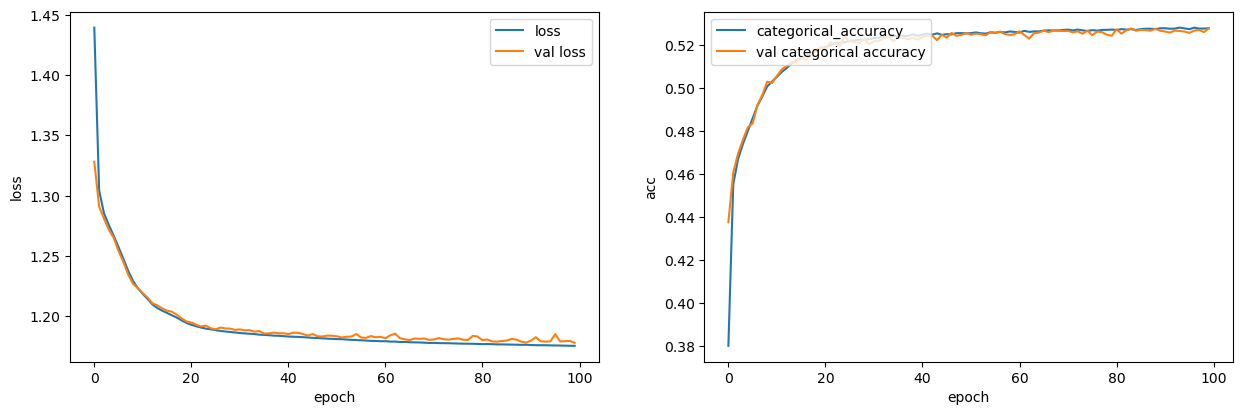

[I 2023-11-18 06:30:12,224] Trial 5 finished with value: 0.5281174778938293 and parameters: {'nlayers': 2, 'nhidden_l0': 11, 'nhidden_l1': 18, 'learning_rate': 0.000490118134467252, 'bsize': 64}. Best is trial 3 with value: 0.6387072801589966.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 12)                588       
                                                                 
 Dense_1 (Dense)             (None, 5)                 65        
                                                                 
Total params: 653
Trainable params: 653
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 06:30:19,878] Trial 6 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 11)                539       
                                                                 
 Dense_1 (Dense)             (None, 12)                144       
                                                                 
 Dense_2 (Dense)             (None, 24)                312       
                                                                 
 Dense_3 (Dense)             (None, 8)                 200       
                                                                 
 Dense_4 (Dense)             (None, 21)                189       
                                                                 
 Dense_5 (Dense)             (None, 5)                 110       
                                                                 
Total params: 1,494
Trainable params: 1,494
Non-traina

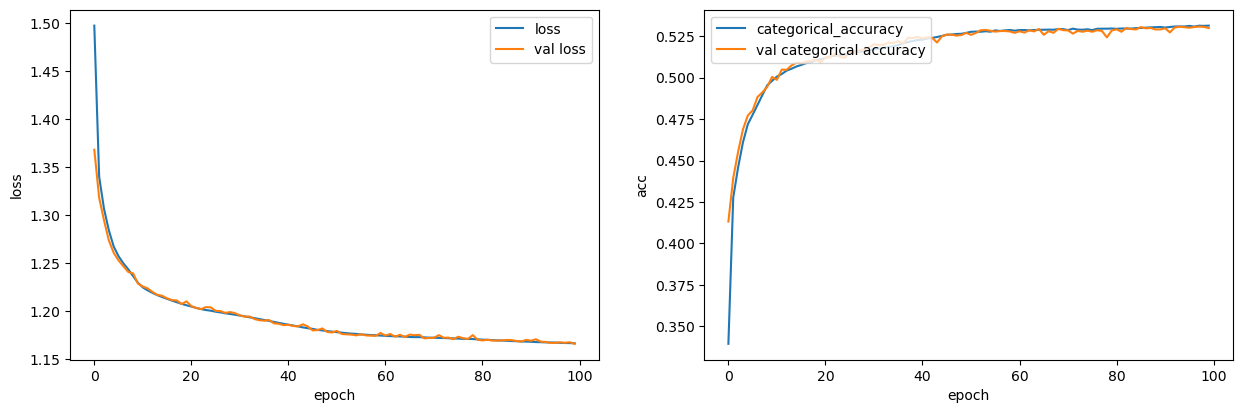

[I 2023-11-18 06:39:19,171] Trial 7 finished with value: 0.5282754898071289 and parameters: {'nlayers': 5, 'nhidden_l0': 11, 'nhidden_l1': 12, 'nhidden_l2': 24, 'nhidden_l3': 8, 'nhidden_l4': 21, 'learning_rate': 0.00013037057460807823, 'bsize': 32}. Best is trial 3 with value: 0.6387072801589966.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 25)                1225      
                                                                 
 Dense_1 (Dense)             (None, 64)                1664      
                                                                 
 Dense_2 (Dense)             (None, 78)                5070      
                                                                 
 Dense_3 (Dense)             (None, 10)                790       
                                                                 
 Dense_4 (Dense)             (None, 78)                858       
                                                                 
 Dense_5 (Dense)             (None, 12)                948       
                                                                 
 Dense_6 (Dense)             (None, 10)               

[I 2023-11-18 06:39:38,735] Trial 8 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 21)                1029      
                                                                 
 Dense_1 (Dense)             (None, 5)                 110       
                                                                 
Total params: 1,139
Trainable params: 1,139
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 06:40:10,781] Trial 9 pruned. Trial was pruned at epoch 27.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 94)                4606      
                                                                 
 Dense_1 (Dense)             (None, 42)                3990      
                                                                 
 Dense_2 (Dense)             (None, 8)                 344       
                                                                 
 Dense_3 (Dense)             (None, 5)                 45        
                                                                 
Total params: 8,985
Trainable params: 8,985
Non-trainable params: 0
_________________________________________________________________


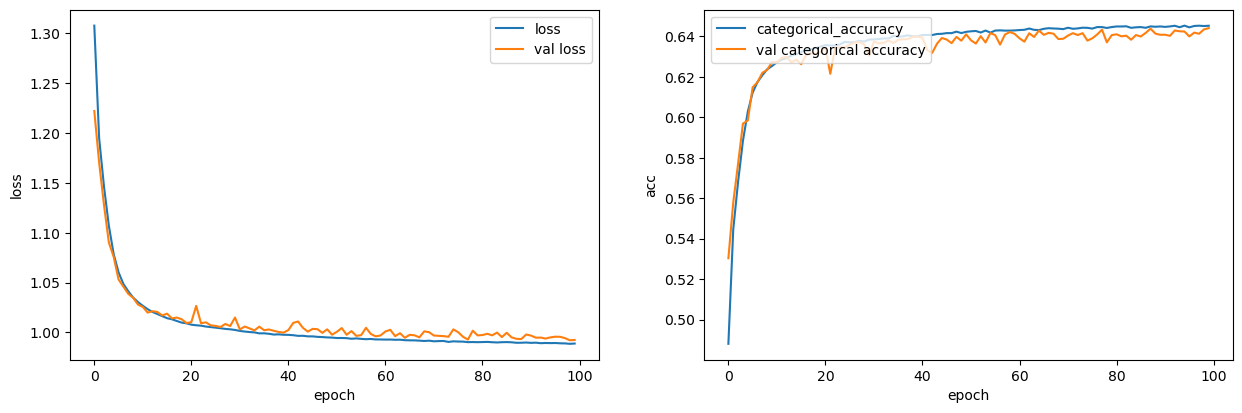

[I 2023-11-18 06:49:13,442] Trial 10 finished with value: 0.6423675417900085 and parameters: {'nlayers': 3, 'nhidden_l0': 94, 'nhidden_l1': 42, 'nhidden_l2': 8, 'learning_rate': 0.00039676986457016025, 'bsize': 32}. Best is trial 10 with value: 0.6423675417900085.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 94)                4606      
                                                                 
 Dense_1 (Dense)             (None, 40)                3800      
                                                                 
 Dense_2 (Dense)             (None, 8)                 328       
                                                                 
 Dense_3 (Dense)             (None, 5)                 45        
                                                                 
Total params: 8,779
Trainable params: 8,779
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 06:49:35,954] Trial 11 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 96)                4704      
                                                                 
 Dense_1 (Dense)             (None, 39)                3783      
                                                                 
 Dense_2 (Dense)             (None, 8)                 320       
                                                                 
 Dense_3 (Dense)             (None, 60)                540       
                                                                 
 Dense_4 (Dense)             (None, 5)                 305       
                                                                 
Total params: 9,652
Trainable params: 9,652
Non-trainable params: 0
_________________________________________________________________


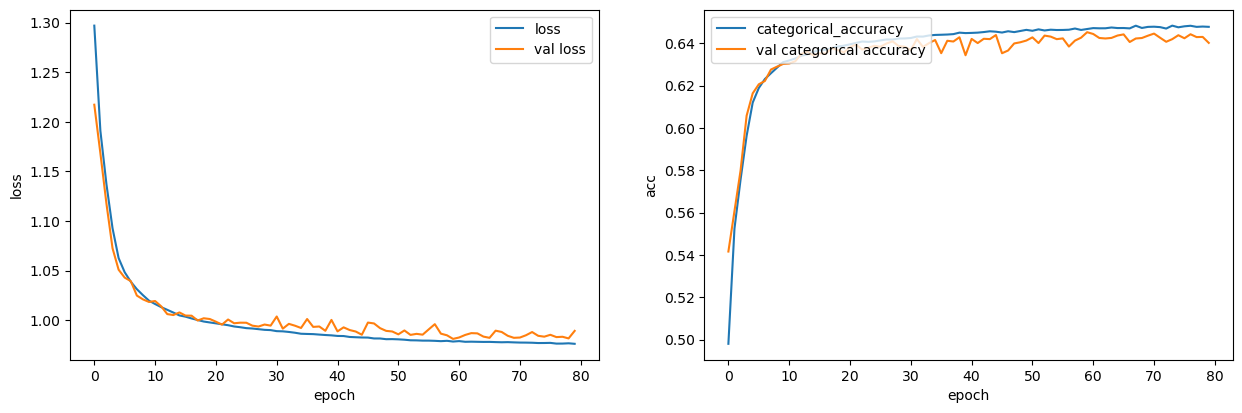

[I 2023-11-18 06:57:45,040] Trial 12 finished with value: 0.6448382139205933 and parameters: {'nlayers': 4, 'nhidden_l0': 96, 'nhidden_l1': 39, 'nhidden_l2': 8, 'nhidden_l3': 60, 'learning_rate': 0.00033987787848300757, 'bsize': 32}. Best is trial 12 with value: 0.6448382139205933.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 87)                4263      
                                                                 
 Dense_1 (Dense)             (None, 90)                7920      
                                                                 
 Dense_2 (Dense)             (None, 8)                 728       
                                                                 
 Dense_3 (Dense)             (None, 86)                774       
                                                                 
 Dense_4 (Dense)             (None, 5)                 435       
                                                                 
Total params: 14,120
Trainable params: 14,120
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 06:58:13,456] Trial 13 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 70)                3430      
                                                                 
 Dense_1 (Dense)             (None, 28)                1988      
                                                                 
 Dense_2 (Dense)             (None, 11)                319       
                                                                 
 Dense_3 (Dense)             (None, 94)                1128      
                                                                 
 Dense_4 (Dense)             (None, 8)                 760       
                                                                 
 Dense_5 (Dense)             (None, 10)                90        
                                                                 
 Dense_6 (Dense)             (None, 5)                

[I 2023-11-18 06:58:27,265] Trial 14 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 96)                4704      
                                                                 
 Dense_1 (Dense)             (None, 32)                3104      
                                                                 
 Dense_2 (Dense)             (None, 13)                429       
                                                                 
 Dense_3 (Dense)             (None, 5)                 70        
                                                                 
Total params: 8,307
Trainable params: 8,307
Non-trainable params: 0
_________________________________________________________________


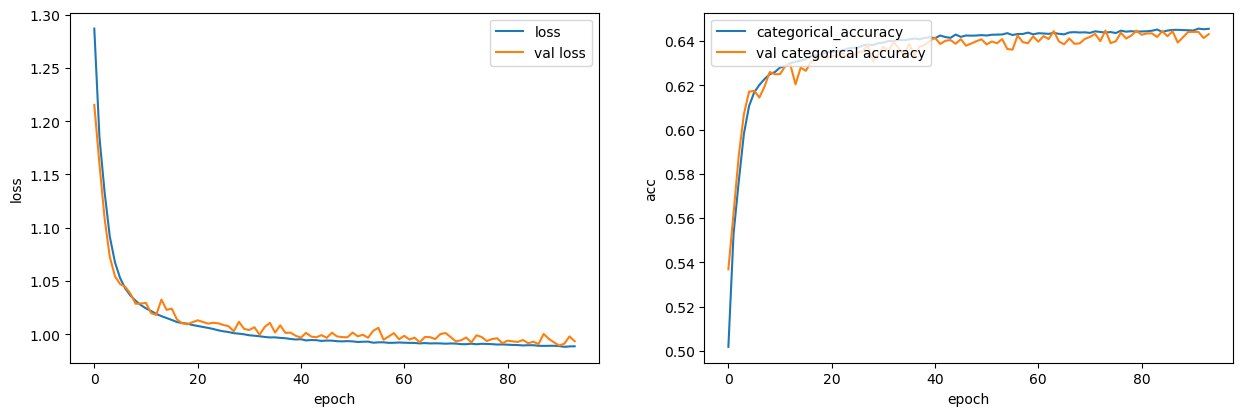

[I 2023-11-18 07:06:34,960] Trial 15 finished with value: 0.6426836252212524 and parameters: {'nlayers': 3, 'nhidden_l0': 96, 'nhidden_l1': 32, 'nhidden_l2': 13, 'learning_rate': 0.00047829045527199055, 'bsize': 32}. Best is trial 12 with value: 0.6448382139205933.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 65)                3185      
                                                                 
 Dense_1 (Dense)             (None, 24)                1584      
                                                                 
 Dense_2 (Dense)             (None, 14)                350       
                                                                 
 Dense_3 (Dense)             (None, 5)                 75        
                                                                 
Total params: 5,194
Trainable params: 5,194
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:06:40,997] Trial 16 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 75)                3675      
                                                                 
 Dense_1 (Dense)             (None, 31)                2356      
                                                                 
 Dense_2 (Dense)             (None, 14)                448       
                                                                 
 Dense_3 (Dense)             (None, 18)                270       
                                                                 
 Dense_4 (Dense)             (None, 83)                1577      
                                                                 
 Dense_5 (Dense)             (None, 43)                3612      
                                                                 
 Dense_6 (Dense)             (None, 5)                

[I 2023-11-18 07:07:10,867] Trial 17 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 69)                3381      
                                                                 
 Dense_1 (Dense)             (None, 19)                1330      
                                                                 
 Dense_2 (Dense)             (None, 5)                 100       
                                                                 
Total params: 4,811
Trainable params: 4,811
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:07:30,093] Trial 18 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 39)                1911      
                                                                 
 Dense_1 (Dense)             (None, 54)                2160      
                                                                 
 Dense_2 (Dense)             (None, 13)                715       
                                                                 
 Dense_3 (Dense)             (None, 59)                826       
                                                                 
 Dense_4 (Dense)             (None, 5)                 300       
                                                                 
Total params: 5,912
Trainable params: 5,912
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:07:37,088] Trial 19 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 57)                2793      
                                                                 
 Dense_1 (Dense)             (None, 34)                1972      
                                                                 
 Dense_2 (Dense)             (None, 5)                 175       
                                                                 
Total params: 4,940
Trainable params: 4,940
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:07:46,896] Trial 20 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 94)                4606      
                                                                 
 Dense_1 (Dense)             (None, 45)                4275      
                                                                 
 Dense_2 (Dense)             (None, 8)                 368       
                                                                 
 Dense_3 (Dense)             (None, 5)                 45        
                                                                 
Total params: 9,294
Trainable params: 9,294
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:08:42,222] Trial 21 pruned. Trial was pruned at epoch 9.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 96)                4704      
                                                                 
 Dense_1 (Dense)             (None, 36)                3492      
                                                                 
 Dense_2 (Dense)             (None, 10)                370       
                                                                 
 Dense_3 (Dense)             (None, 5)                 55        
                                                                 
Total params: 8,621
Trainable params: 8,621
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:09:34,840] Trial 22 pruned. Trial was pruned at epoch 9.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 82)                4018      
                                                                 
 Dense_1 (Dense)             (None, 54)                4482      
                                                                 
 Dense_2 (Dense)             (None, 10)                550       
                                                                 
 Dense_3 (Dense)             (None, 23)                253       
                                                                 
 Dense_4 (Dense)             (None, 9)                 216       
                                                                 
 Dense_5 (Dense)             (None, 5)                 50        
                                                                 
Total params: 9,569
Trainable params: 9,569
Non-traina

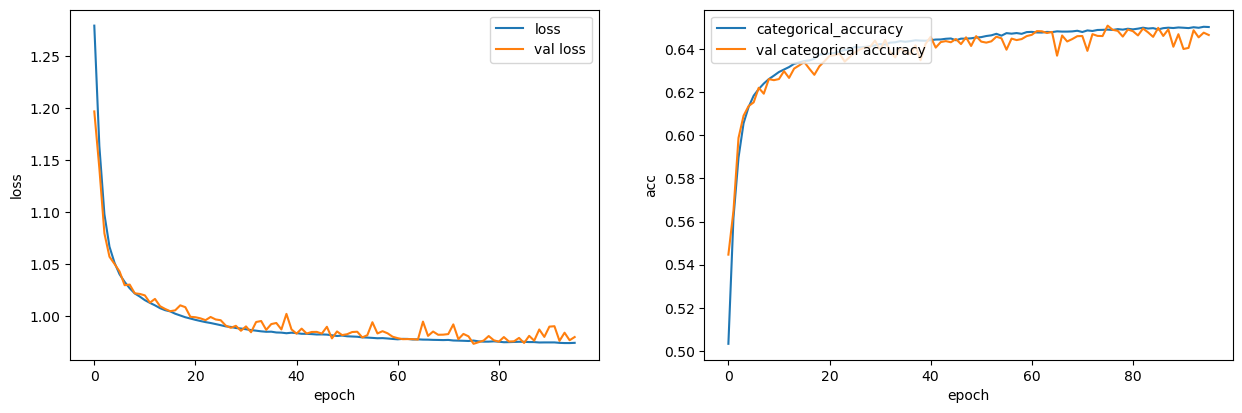

[I 2023-11-18 07:19:59,856] Trial 23 finished with value: 0.6483986377716064 and parameters: {'nlayers': 5, 'nhidden_l0': 82, 'nhidden_l1': 54, 'nhidden_l2': 10, 'nhidden_l3': 23, 'nhidden_l4': 9, 'learning_rate': 0.0004971325885917807, 'bsize': 32}. Best is trial 23 with value: 0.6483986377716064.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 73)                3577      
                                                                 
 Dense_1 (Dense)             (None, 62)                4588      
                                                                 
 Dense_2 (Dense)             (None, 18)                1134      
                                                                 
 Dense_3 (Dense)             (None, 20)                380       
                                                                 
 Dense_4 (Dense)             (None, 8)                 168       
                                                                 
 Dense_5 (Dense)             (None, 5)                 45        
                                                                 
Total params: 9,892
Trainable params: 9,892
Non-traina

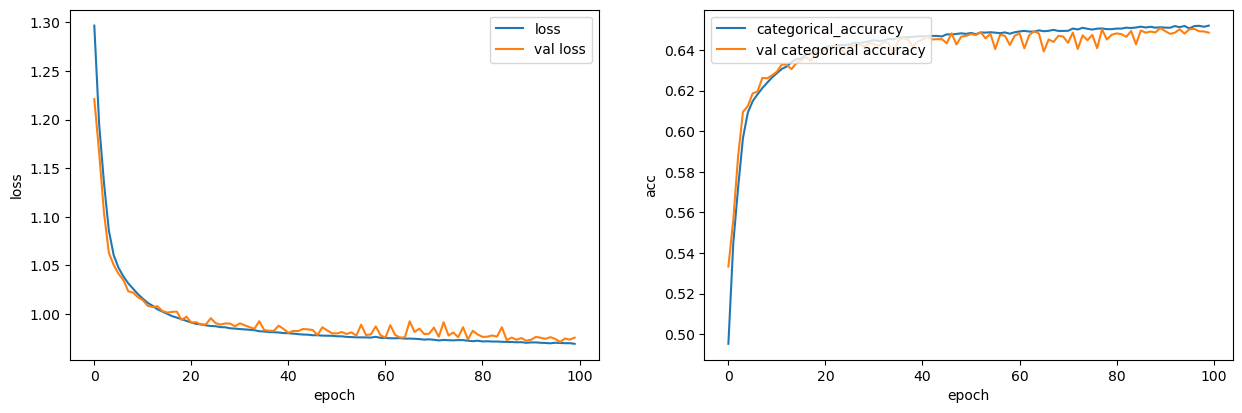

[I 2023-11-18 07:30:18,647] Trial 24 finished with value: 0.6487230658531189 and parameters: {'nlayers': 5, 'nhidden_l0': 73, 'nhidden_l1': 62, 'nhidden_l2': 18, 'nhidden_l3': 20, 'nhidden_l4': 8, 'learning_rate': 0.000464517602581388, 'bsize': 32}. Best is trial 24 with value: 0.6487230658531189.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 70)                3430      
                                                                 
 Dense_1 (Dense)             (None, 64)                4544      
                                                                 
 Dense_2 (Dense)             (None, 18)                1170      
                                                                 
 Dense_3 (Dense)             (None, 20)                380       
                                                                 
 Dense_4 (Dense)             (None, 8)                 168       
                                                                 
 Dense_5 (Dense)             (None, 23)                207       
                                                                 
 Dense_6 (Dense)             (None, 5)                

[I 2023-11-18 07:30:32,510] Trial 25 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 77)                3773      
                                                                 
 Dense_1 (Dense)             (None, 86)                6708      
                                                                 
 Dense_2 (Dense)             (None, 17)                1479      
                                                                 
 Dense_3 (Dense)             (None, 23)                414       
                                                                 
 Dense_4 (Dense)             (None, 12)                288       
                                                                 
 Dense_5 (Dense)             (None, 5)                 65        
                                                                 
Total params: 12,727
Trainable params: 12,727
Non-trai

[I 2023-11-18 07:31:42,088] Trial 26 pruned. Trial was pruned at epoch 9.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 56)                2744      
                                                                 
 Dense_1 (Dense)             (None, 52)                2964      
                                                                 
 Dense_2 (Dense)             (None, 11)                583       
                                                                 
 Dense_3 (Dense)             (None, 29)                348       
                                                                 
 Dense_4 (Dense)             (None, 13)                390       
                                                                 
 Dense_5 (Dense)             (None, 8)                 112       
                                                                 
 Dense_6 (Dense)             (None, 93)               

[I 2023-11-18 07:31:57,679] Trial 27 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 79)                3871      
                                                                 
 Dense_1 (Dense)             (None, 71)                5680      
                                                                 
 Dense_2 (Dense)             (None, 10)                720       
                                                                 
 Dense_3 (Dense)             (None, 15)                165       
                                                                 
 Dense_4 (Dense)             (None, 13)                208       
                                                                 
 Dense_5 (Dense)             (None, 5)                 70        
                                                                 
Total params: 10,714
Trainable params: 10,714
Non-trai

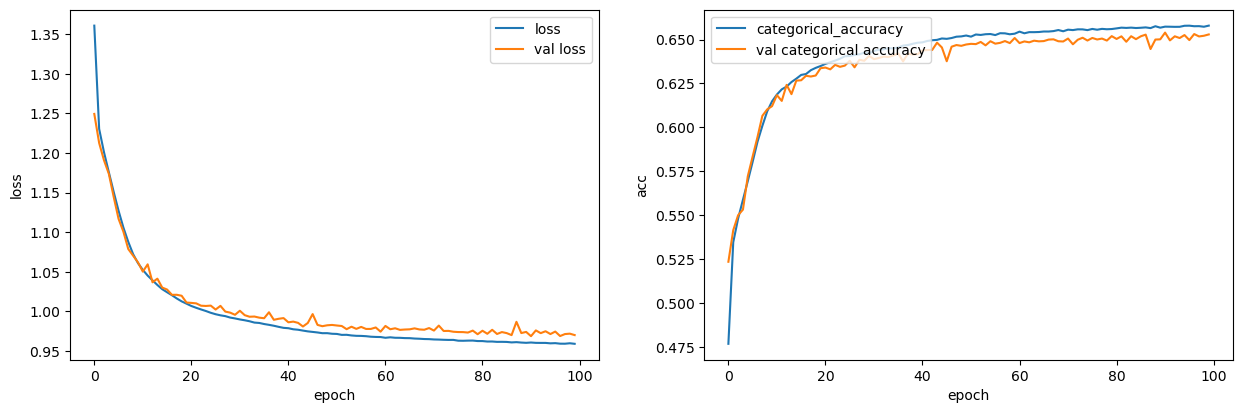

[I 2023-11-18 07:35:47,359] Trial 28 finished with value: 0.6528741121292114 and parameters: {'nlayers': 5, 'nhidden_l0': 79, 'nhidden_l1': 71, 'nhidden_l2': 10, 'nhidden_l3': 15, 'nhidden_l4': 13, 'learning_rate': 0.00040073250592564496, 'bsize': 128}. Best is trial 28 with value: 0.6528741121292114.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 80)                3920      
                                                                 
 Dense_1 (Dense)             (None, 71)                5751      
                                                                 
 Dense_2 (Dense)             (None, 20)                1440      
                                                                 
 Dense_3 (Dense)             (None, 15)                315       
                                                                 
 Dense_4 (Dense)             (None, 12)                192       
                                                                 
 Dense_5 (Dense)             (None, 5)                 65        
                                                                 
Total params: 11,683
Trainable params: 11,683
Non-trai

[I 2023-11-18 07:35:52,211] Trial 29 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 62)                3038      
                                                                 
 Dense_1 (Dense)             (None, 76)                4788      
                                                                 
 Dense_2 (Dense)             (None, 10)                770       
                                                                 
 Dense_3 (Dense)             (None, 14)                154       
                                                                 
 Dense_4 (Dense)             (None, 8)                 120       
                                                                 
 Dense_5 (Dense)             (None, 23)                207       
                                                                 
 Dense_6 (Dense)             (None, 8)                

[I 2023-11-18 07:35:56,824] Trial 30 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 80)                3920      
                                                                 
 Dense_1 (Dense)             (None, 55)                4455      
                                                                 
 Dense_2 (Dense)             (None, 10)                560       
                                                                 
 Dense_3 (Dense)             (None, 24)                264       
                                                                 
 Dense_4 (Dense)             (None, 5)                 125       
                                                                 
Total params: 9,324
Trainable params: 9,324
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:36:01,004] Trial 31 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 79)                3871      
                                                                 
 Dense_1 (Dense)             (None, 95)                7600      
                                                                 
 Dense_2 (Dense)             (None, 10)                960       
                                                                 
 Dense_3 (Dense)             (None, 16)                176       
                                                                 
 Dense_4 (Dense)             (None, 15)                255       
                                                                 
 Dense_5 (Dense)             (None, 84)                1344      
                                                                 
 Dense_6 (Dense)             (None, 5)                

[I 2023-11-18 07:36:12,805] Trial 32 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 53)                2597      
                                                                 
 Dense_1 (Dense)             (None, 53)                2862      
                                                                 
 Dense_2 (Dense)             (None, 16)                864       
                                                                 
 Dense_3 (Dense)             (None, 28)                476       
                                                                 
 Dense_4 (Dense)             (None, 10)                290       
                                                                 
 Dense_5 (Dense)             (None, 5)                 55        
                                                                 
Total params: 7,144
Trainable params: 7,144
Non-traina

[I 2023-11-18 07:36:17,203] Trial 33 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 66)                3234      
                                                                 
 Dense_1 (Dense)             (None, 73)                4891      
                                                                 
 Dense_2 (Dense)             (None, 12)                888       
                                                                 
 Dense_3 (Dense)             (None, 20)                260       
                                                                 
 Dense_4 (Dense)             (None, 5)                 105       
                                                                 
Total params: 9,378
Trainable params: 9,378
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:36:21,494] Trial 34 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 81)                3969      
                                                                 
 Dense_1 (Dense)             (None, 61)                5002      
                                                                 
 Dense_2 (Dense)             (None, 9)                 558       
                                                                 
 Dense_3 (Dense)             (None, 13)                130       
                                                                 
 Dense_4 (Dense)             (None, 18)                252       
                                                                 
 Dense_5 (Dense)             (None, 5)                 95        
                                                                 
Total params: 10,006
Trainable params: 10,006
Non-trai

[I 2023-11-18 07:36:29,683] Trial 35 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 48)                2352      
                                                                 
 Dense_1 (Dense)             (None, 45)                2205      
                                                                 
 Dense_2 (Dense)             (None, 12)                552       
                                                                 
 Dense_3 (Dense)             (None, 19)                247       
                                                                 
 Dense_4 (Dense)             (None, 10)                200       
                                                                 
 Dense_5 (Dense)             (None, 45)                495       
                                                                 
 Dense_6 (Dense)             (None, 5)                

[I 2023-11-18 07:36:43,555] Trial 36 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 61)                2989      
                                                                 
 Dense_1 (Dense)             (None, 79)                4898      
                                                                 
 Dense_2 (Dense)             (None, 15)                1200      
                                                                 
 Dense_3 (Dense)             (None, 12)                192       
                                                                 
 Dense_4 (Dense)             (None, 5)                 65        
                                                                 
Total params: 9,344
Trainable params: 9,344
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:39:15,612] Trial 37 pruned. Trial was pruned at epoch 81.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 43)                2107      
                                                                 
 Dense_1 (Dense)             (None, 49)                2156      
                                                                 
 Dense_2 (Dense)             (None, 29)                1450      
                                                                 
 Dense_3 (Dense)             (None, 24)                720       
                                                                 
 Dense_4 (Dense)             (None, 16)                400       
                                                                 
 Dense_5 (Dense)             (None, 5)                 85        
                                                                 
Total params: 6,918
Trainable params: 6,918
Non-traina

[I 2023-11-18 07:39:28,524] Trial 38 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 50)                2450      
                                                                 
 Dense_1 (Dense)             (None, 61)                3111      
                                                                 
 Dense_2 (Dense)             (None, 9)                 558       
                                                                 
 Dense_3 (Dense)             (None, 34)                340       
                                                                 
 Dense_4 (Dense)             (None, 5)                 175       
                                                                 
Total params: 6,634
Trainable params: 6,634
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:39:52,775] Trial 39 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 33)                1617      
                                                                 
 Dense_1 (Dense)             (None, 39)                1326      
                                                                 
 Dense_2 (Dense)             (None, 21)                840       
                                                                 
 Dense_3 (Dense)             (None, 16)                352       
                                                                 
 Dense_4 (Dense)             (None, 10)                170       
                                                                 
 Dense_5 (Dense)             (None, 16)                176       
                                                                 
 Dense_6 (Dense)             (None, 21)               

[I 2023-11-18 07:40:08,160] Trial 40 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 86)                4214      
                                                                 
 Dense_1 (Dense)             (None, 48)                4176      
                                                                 
 Dense_2 (Dense)             (None, 13)                637       
                                                                 
 Dense_3 (Dense)             (None, 24)                336       
                                                                 
 Dense_4 (Dense)             (None, 23)                575       
                                                                 
 Dense_5 (Dense)             (None, 5)                 120       
                                                                 
Total params: 10,058
Trainable params: 10,058
Non-trai

[I 2023-11-18 07:49:24,088] Trial 41 pruned. Trial was pruned at epoch 81.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 96)                4704      
                                                                 
 Dense_1 (Dense)             (None, 38)                3686      
                                                                 
 Dense_2 (Dense)             (None, 12)                468       
                                                                 
 Dense_3 (Dense)             (None, 18)                234       
                                                                 
 Dense_4 (Dense)             (None, 5)                 95        
                                                                 
Total params: 9,187
Trainable params: 9,187
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:50:21,694] Trial 42 pruned. Trial was pruned at epoch 9.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 61)                2989      
                                                                 
 Dense_1 (Dense)             (None, 44)                2728      
                                                                 
 Dense_2 (Dense)             (None, 14)                630       
                                                                 
 Dense_3 (Dense)             (None, 5)                 75        
                                                                 
Total params: 6,422
Trainable params: 6,422
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:50:42,599] Trial 43 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 73)                3577      
                                                                 
 Dense_1 (Dense)             (None, 68)                5032      
                                                                 
 Dense_2 (Dense)             (None, 5)                 345       
                                                                 
Total params: 8,954
Trainable params: 8,954
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:51:02,787] Trial 44 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 84)                4116      
                                                                 
 Dense_1 (Dense)             (None, 58)                4930      
                                                                 
 Dense_2 (Dense)             (None, 34)                2006      
                                                                 
 Dense_3 (Dense)             (None, 34)                1190      
                                                                 
 Dense_4 (Dense)             (None, 14)                490       
                                                                 
 Dense_5 (Dense)             (None, 5)                 75        
                                                                 
Total params: 12,807
Trainable params: 12,807
Non-trai

[I 2023-11-18 07:51:16,298] Trial 45 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 86)                4214      
                                                                 
 Dense_1 (Dense)             (None, 81)                7047      
                                                                 
 Dense_2 (Dense)             (None, 9)                 738       
                                                                 
 Dense_3 (Dense)             (None, 11)                110       
                                                                 
 Dense_4 (Dense)             (None, 10)                120       
                                                                 
 Dense_5 (Dense)             (None, 15)                165       
                                                                 
 Dense_6 (Dense)             (None, 5)                

[I 2023-11-18 07:51:22,339] Trial 46 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 71)                3479      
                                                                 
 Dense_1 (Dense)             (None, 33)                2376      
                                                                 
 Dense_2 (Dense)             (None, 16)                544       
                                                                 
 Dense_3 (Dense)             (None, 30)                510       
                                                                 
 Dense_4 (Dense)             (None, 5)                 155       
                                                                 
Total params: 7,064
Trainable params: 7,064
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:52:23,645] Trial 47 pruned. Trial was pruned at epoch 9.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 88)                4312      
                                                                 
 Dense_1 (Dense)             (None, 40)                3560      
                                                                 
 Dense_2 (Dense)             (None, 8)                 328       
                                                                 
 Dense_3 (Dense)             (None, 5)                 45        
                                                                 
Total params: 8,245
Trainable params: 8,245
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:53:16,066] Trial 48 pruned. Trial was pruned at epoch 9.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 66)                3234      
                                                                 
 Dense_1 (Dense)             (None, 67)                4489      
                                                                 
 Dense_2 (Dense)             (None, 12)                816       
                                                                 
 Dense_3 (Dense)             (None, 43)                559       
                                                                 
 Dense_4 (Dense)             (None, 8)                 352       
                                                                 
 Dense_5 (Dense)             (None, 5)                 45        
                                                                 
Total params: 9,495
Trainable params: 9,495
Non-traina

[I 2023-11-18 07:53:23,784] Trial 49 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 76)                3724      
                                                                 
 Dense_1 (Dense)             (None, 31)                2387      
                                                                 
 Dense_2 (Dense)             (None, 9)                 288       
                                                                 
 Dense_3 (Dense)             (None, 22)                220       
                                                                 
 Dense_4 (Dense)             (None, 17)                391       
                                                                 
 Dense_5 (Dense)             (None, 8)                 144       
                                                                 
 Dense_6 (Dense)             (None, 5)                

[I 2023-11-18 07:53:37,122] Trial 50 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 95)                4655      
                                                                 
 Dense_1 (Dense)             (None, 41)                3936      
                                                                 
 Dense_2 (Dense)             (None, 8)                 336       
                                                                 
 Dense_3 (Dense)             (None, 5)                 45        
                                                                 
Total params: 8,972
Trainable params: 8,972
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:54:32,278] Trial 51 pruned. Trial was pruned at epoch 9.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 87)                4263      
                                                                 
 Dense_1 (Dense)             (None, 28)                2464      
                                                                 
 Dense_2 (Dense)             (None, 5)                 145       
                                                                 
Total params: 6,872
Trainable params: 6,872
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:54:51,345] Trial 52 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 77)                3773      
                                                                 
 Dense_1 (Dense)             (None, 47)                3666      
                                                                 
 Dense_2 (Dense)             (None, 11)                528       
                                                                 
 Dense_3 (Dense)             (None, 5)                 60        
                                                                 
Total params: 8,027
Trainable params: 8,027
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:55:44,677] Trial 53 pruned. Trial was pruned at epoch 9.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 71)                3479      
                                                                 
 Dense_1 (Dense)             (None, 58)                4176      
                                                                 
 Dense_2 (Dense)             (None, 8)                 472       
                                                                 
 Dense_3 (Dense)             (None, 15)                135       
                                                                 
 Dense_4 (Dense)             (None, 5)                 80        
                                                                 
Total params: 8,342
Trainable params: 8,342
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:56:06,949] Trial 54 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 96)                4704      
                                                                 
 Dense_1 (Dense)             (None, 35)                3395      
                                                                 
 Dense_2 (Dense)             (None, 5)                 180       
                                                                 
Total params: 8,279
Trainable params: 8,279
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:56:26,590] Trial 55 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 88)                4312      
                                                                 
 Dense_1 (Dense)             (None, 50)                4450      
                                                                 
 Dense_2 (Dense)             (None, 9)                 459       
                                                                 
 Dense_3 (Dense)             (None, 5)                 50        
                                                                 
Total params: 9,271
Trainable params: 9,271
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:58:51,558] Trial 56 pruned. Trial was pruned at epoch 27.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 59)                2891      
                                                                 
 Dense_1 (Dense)             (None, 25)                1500      
                                                                 
 Dense_2 (Dense)             (None, 11)                286       
                                                                 
 Dense_3 (Dense)             (None, 39)                468       
                                                                 
 Dense_4 (Dense)             (None, 5)                 200       
                                                                 
Total params: 5,345
Trainable params: 5,345
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:59:15,491] Trial 57 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 67)                3283      
                                                                 
 Dense_1 (Dense)             (None, 5)                 340       
                                                                 
Total params: 3,623
Trainable params: 3,623
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 07:59:18,511] Trial 58 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 73)                3577      
                                                                 
 Dense_1 (Dense)             (None, 42)                3108      
                                                                 
 Dense_2 (Dense)             (None, 14)                602       
                                                                 
 Dense_3 (Dense)             (None, 53)                795       
                                                                 
 Dense_4 (Dense)             (None, 12)                648       
                                                                 
 Dense_5 (Dense)             (None, 5)                 65        
                                                                 
Total params: 8,795
Trainable params: 8,795
Non-traina

[I 2023-11-18 08:00:21,650] Trial 59 pruned. Trial was pruned at epoch 9.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 53)                2597      
                                                                 
 Dense_1 (Dense)             (None, 65)                3510      
                                                                 
 Dense_2 (Dense)             (None, 10)                660       
                                                                 
 Dense_3 (Dense)             (None, 26)                286       
                                                                 
 Dense_4 (Dense)             (None, 5)                 135       
                                                                 
Total params: 7,188
Trainable params: 7,188
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 08:00:46,330] Trial 60 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 80)                3920      
                                                                 
 Dense_1 (Dense)             (None, 37)                2997      
                                                                 
 Dense_2 (Dense)             (None, 58)                2204      
                                                                 
 Dense_3 (Dense)             (None, 73)                4307      
                                                                 
 Dense_4 (Dense)             (None, 10)                740       
                                                                 
 Dense_5 (Dense)             (None, 5)                 55        
                                                                 
Total params: 14,223
Trainable params: 14,223
Non-trai

[I 2023-11-18 08:01:53,089] Trial 61 pruned. Trial was pruned at epoch 9.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 89)                4361      
                                                                 
 Dense_1 (Dense)             (None, 44)                3960      
                                                                 
 Dense_2 (Dense)             (None, 96)                4320      
                                                                 
 Dense_3 (Dense)             (None, 5)                 485       
                                                                 
Total params: 13,126
Trainable params: 13,126
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 08:04:41,006] Trial 62 pruned. Trial was pruned at epoch 27.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 64)                3136      
                                                                 
 Dense_1 (Dense)             (None, 54)                3510      
                                                                 
 Dense_2 (Dense)             (None, 45)                2475      
                                                                 
 Dense_3 (Dense)             (None, 52)                2392      
                                                                 
 Dense_4 (Dense)             (None, 5)                 265       
                                                                 
Total params: 11,778
Trainable params: 11,778
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 08:05:06,661] Trial 63 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 81)                3969      
                                                                 
 Dense_1 (Dense)             (None, 32)                2624      
                                                                 
 Dense_2 (Dense)             (None, 21)                693       
                                                                 
 Dense_3 (Dense)             (None, 5)                 110       
                                                                 
Total params: 7,396
Trainable params: 7,396
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 08:05:37,852] Trial 64 pruned. Trial was pruned at epoch 9.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 74)                3626      
                                                                 
 Dense_1 (Dense)             (None, 50)                3750      
                                                                 
 Dense_2 (Dense)             (None, 25)                1275      
                                                                 
 Dense_3 (Dense)             (None, 67)                1742      
                                                                 
 Dense_4 (Dense)             (None, 27)                1836      
                                                                 
 Dense_5 (Dense)             (None, 5)                 140       
                                                                 
Total params: 12,369
Trainable params: 12,369
Non-trai

[I 2023-11-18 08:05:47,656] Trial 65 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 96)                4704      
                                                                 
 Dense_1 (Dense)             (None, 35)                3395      
                                                                 
 Dense_2 (Dense)             (None, 19)                684       
                                                                 
 Dense_3 (Dense)             (None, 39)                780       
                                                                 
 Dense_4 (Dense)             (None, 14)                560       
                                                                 
 Dense_5 (Dense)             (None, 36)                540       
                                                                 
 Dense_6 (Dense)             (None, 90)               

[I 2023-11-18 08:07:17,840] Trial 66 pruned. Trial was pruned at epoch 9.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 57)                2793      
                                                                 
 Dense_1 (Dense)             (None, 42)                2436      
                                                                 
 Dense_2 (Dense)             (None, 17)                731       
                                                                 
 Dense_3 (Dense)             (None, 9)                 162       
                                                                 
 Dense_4 (Dense)             (None, 38)                380       
                                                                 
 Dense_5 (Dense)             (None, 59)                2301      
                                                                 
 Dense_6 (Dense)             (None, 5)                

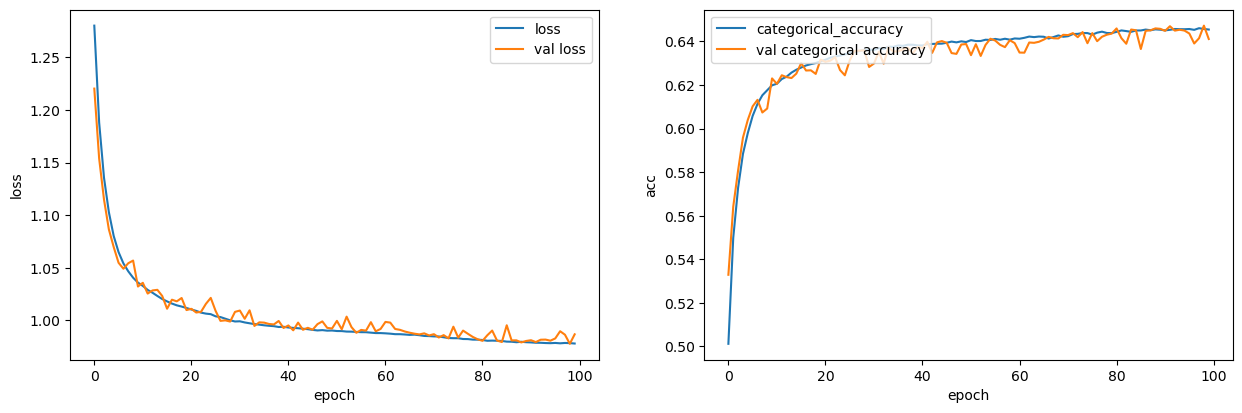

[I 2023-11-18 08:19:07,179] Trial 67 finished with value: 0.6471009254455566 and parameters: {'nlayers': 6, 'nhidden_l0': 57, 'nhidden_l1': 42, 'nhidden_l2': 17, 'nhidden_l3': 9, 'nhidden_l4': 38, 'nhidden_l5': 59, 'learning_rate': 0.00047463688157059914, 'bsize': 32}. Best is trial 28 with value: 0.6528741121292114.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 67)                3283      
                                                                 
 Dense_1 (Dense)             (None, 42)                2856      
                                                                 
 Dense_2 (Dense)             (None, 17)                731       
                                                                 
 Dense_3 (Dense)             (None, 9)                 162       
                                                                 
 Dense_4 (Dense)             (None, 45)                450       
                                                                 
 Dense_5 (Dense)             (None, 62)                2852      
                                                                 
 Dense_6 (Dense)             (None, 5)                

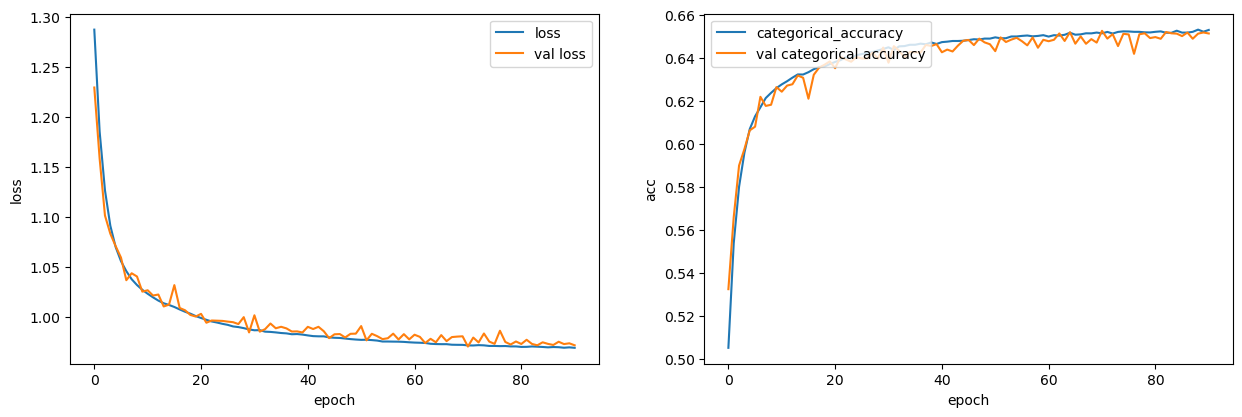

[I 2023-11-18 08:29:55,461] Trial 68 finished with value: 0.6519008278846741 and parameters: {'nlayers': 6, 'nhidden_l0': 67, 'nhidden_l1': 42, 'nhidden_l2': 17, 'nhidden_l3': 9, 'nhidden_l4': 45, 'nhidden_l5': 62, 'learning_rate': 0.0004763206930413807, 'bsize': 32}. Best is trial 28 with value: 0.6528741121292114.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 58)                2842      
                                                                 
 Dense_1 (Dense)             (None, 58)                3422      
                                                                 
 Dense_2 (Dense)             (None, 18)                1062      
                                                                 
 Dense_3 (Dense)             (None, 8)                 152       
                                                                 
 Dense_4 (Dense)             (None, 44)                396       
                                                                 
 Dense_5 (Dense)             (None, 63)                2835      
                                                                 
 Dense_6 (Dense)             (None, 5)                

[I 2023-11-18 08:30:23,816] Trial 69 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 66)                3234      
                                                                 
 Dense_1 (Dense)             (None, 71)                4757      
                                                                 
 Dense_2 (Dense)             (None, 16)                1152      
                                                                 
 Dense_3 (Dense)             (None, 9)                 153       
                                                                 
 Dense_4 (Dense)             (None, 42)                420       
                                                                 
 Dense_5 (Dense)             (None, 67)                2881      
                                                                 
 Dense_6 (Dense)             (None, 19)               

[I 2023-11-18 08:30:30,061] Trial 70 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 90)                4410      
                                                                 
 Dense_1 (Dense)             (None, 41)                3731      
                                                                 
 Dense_2 (Dense)             (None, 13)                546       
                                                                 
 Dense_3 (Dense)             (None, 9)                 126       
                                                                 
 Dense_4 (Dense)             (None, 36)                360       
                                                                 
 Dense_5 (Dense)             (None, 62)                2294      
                                                                 
 Dense_6 (Dense)             (None, 5)                

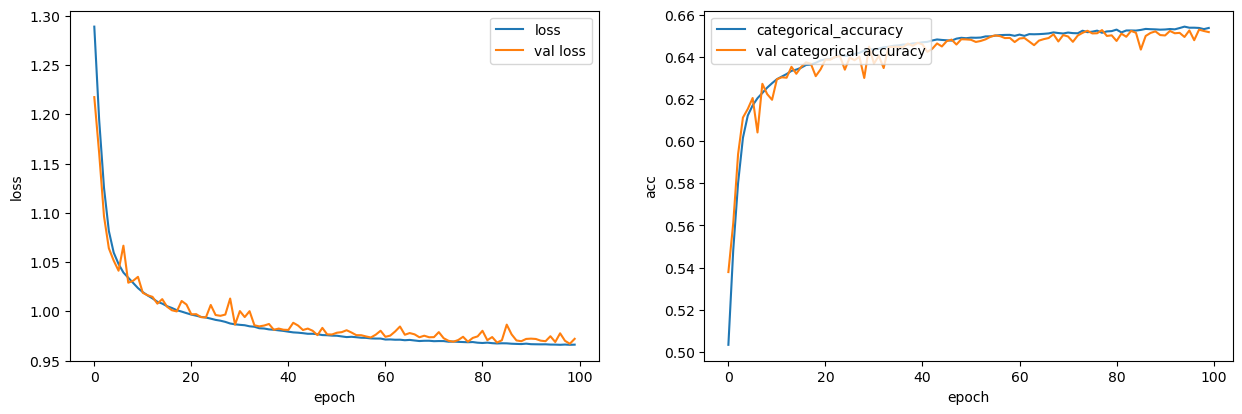

[I 2023-11-18 08:42:55,021] Trial 71 finished with value: 0.6527826189994812 and parameters: {'nlayers': 6, 'nhidden_l0': 90, 'nhidden_l1': 41, 'nhidden_l2': 13, 'nhidden_l3': 9, 'nhidden_l4': 36, 'nhidden_l5': 62, 'learning_rate': 0.0004443337778846281, 'bsize': 32}. Best is trial 28 with value: 0.6528741121292114.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 84)                4116      
                                                                 
 Dense_1 (Dense)             (None, 42)                3570      
                                                                 
 Dense_2 (Dense)             (None, 15)                645       
                                                                 
 Dense_3 (Dense)             (None, 9)                 144       
                                                                 
 Dense_4 (Dense)             (None, 35)                350       
                                                                 
 Dense_5 (Dense)             (None, 66)                2376      
                                                                 
 Dense_6 (Dense)             (None, 5)                

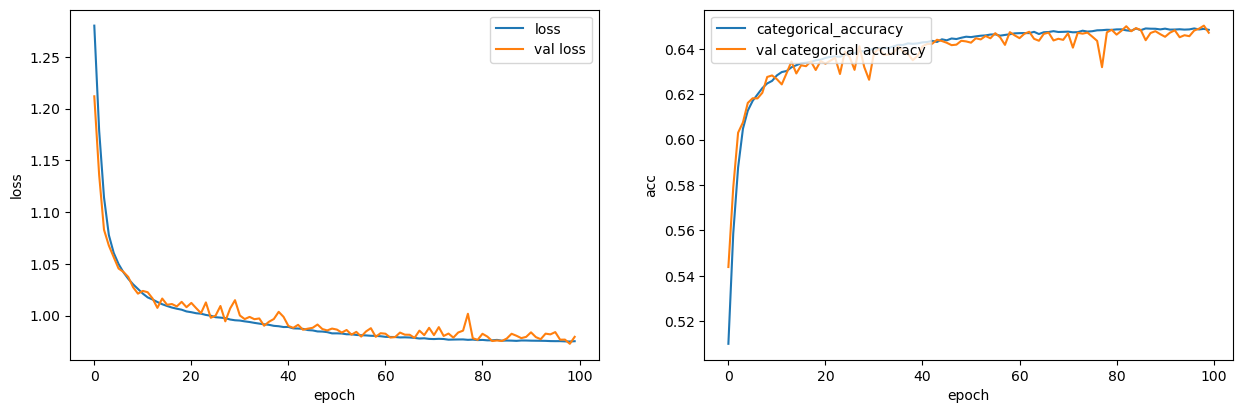

[I 2023-11-18 08:54:53,786] Trial 72 finished with value: 0.6485567092895508 and parameters: {'nlayers': 6, 'nhidden_l0': 84, 'nhidden_l1': 42, 'nhidden_l2': 15, 'nhidden_l3': 9, 'nhidden_l4': 35, 'nhidden_l5': 66, 'learning_rate': 0.00048128069818386874, 'bsize': 32}. Best is trial 28 with value: 0.6528741121292114.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 82)                4018      
                                                                 
 Dense_1 (Dense)             (None, 40)                3320      
                                                                 
 Dense_2 (Dense)             (None, 15)                615       
                                                                 
 Dense_3 (Dense)             (None, 9)                 144       
                                                                 
 Dense_4 (Dense)             (None, 35)                350       
                                                                 
 Dense_5 (Dense)             (None, 61)                2196      
                                                                 
 Dense_6 (Dense)             (None, 5)                

[I 2023-11-18 08:58:18,960] Trial 73 pruned. Trial was pruned at epoch 27.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 69)                3381      
                                                                 
 Dense_1 (Dense)             (None, 46)                3220      
                                                                 
 Dense_2 (Dense)             (None, 17)                799       
                                                                 
 Dense_3 (Dense)             (None, 10)                180       
                                                                 
 Dense_4 (Dense)             (None, 33)                363       
                                                                 
 Dense_5 (Dense)             (None, 53)                1802      
                                                                 
 Dense_6 (Dense)             (None, 44)               

[I 2023-11-18 09:01:50,668] Trial 74 pruned. Trial was pruned at epoch 27.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 63)                3087      
                                                                 
 Dense_1 (Dense)             (None, 51)                3264      
                                                                 
 Dense_2 (Dense)             (None, 13)                676       
                                                                 
 Dense_3 (Dense)             (None, 11)                154       
                                                                 
 Dense_4 (Dense)             (None, 38)                456       
                                                                 
 Dense_5 (Dense)             (None, 74)                2886      
                                                                 
 Dense_6 (Dense)             (None, 5)                

[I 2023-11-18 09:03:03,110] Trial 75 pruned. Trial was pruned at epoch 9.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 76)                3724      
                                                                 
 Dense_1 (Dense)             (None, 37)                2849      
                                                                 
 Dense_2 (Dense)             (None, 22)                836       
                                                                 
 Dense_3 (Dense)             (None, 8)                 184       
                                                                 
 Dense_4 (Dense)             (None, 53)                477       
                                                                 
 Dense_5 (Dense)             (None, 95)                5130      
                                                                 
 Dense_6 (Dense)             (None, 5)                

[I 2023-11-18 09:04:17,212] Trial 76 pruned. Trial was pruned at epoch 9.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 89)                4361      
                                                                 
 Dense_1 (Dense)             (None, 44)                3960      
                                                                 
 Dense_2 (Dense)             (None, 18)                810       
                                                                 
 Dense_3 (Dense)             (None, 10)                190       
                                                                 
 Dense_4 (Dense)             (None, 27)                297       
                                                                 
 Dense_5 (Dense)             (None, 52)                1456      
                                                                 
 Dense_6 (Dense)             (None, 13)               

[I 2023-11-18 09:05:32,035] Trial 77 pruned. Trial was pruned at epoch 9.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 56)                2744      
                                                                 
 Dense_1 (Dense)             (None, 55)                3135      
                                                                 
 Dense_2 (Dense)             (None, 15)                840       
                                                                 
 Dense_3 (Dense)             (None, 9)                 144       
                                                                 
 Dense_4 (Dense)             (None, 31)                310       
                                                                 
 Dense_5 (Dense)             (None, 72)                2304      
                                                                 
 Dense_6 (Dense)             (None, 5)                

[I 2023-11-18 09:05:40,709] Trial 78 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 83)                4067      
                                                                 
 Dense_1 (Dense)             (None, 48)                4032      
                                                                 
 Dense_2 (Dense)             (None, 17)                833       
                                                                 
 Dense_3 (Dense)             (None, 12)                216       
                                                                 
 Dense_4 (Dense)             (None, 49)                637       
                                                                 
 Dense_5 (Dense)             (None, 36)                1800      
                                                                 
 Dense_6 (Dense)             (None, 5)                

[I 2023-11-18 09:05:45,874] Trial 79 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 69)                3381      
                                                                 
 Dense_1 (Dense)             (None, 62)                4340      
                                                                 
 Dense_2 (Dense)             (None, 19)                1197      
                                                                 
 Dense_3 (Dense)             (None, 8)                 160       
                                                                 
 Dense_4 (Dense)             (None, 38)                342       
                                                                 
 Dense_5 (Dense)             (None, 5)                 195       
                                                                 
Total params: 9,615
Trainable params: 9,615
Non-traina

[I 2023-11-18 09:06:11,939] Trial 80 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 89)                4361      
                                                                 
 Dense_1 (Dense)             (None, 38)                3420      
                                                                 
 Dense_2 (Dense)             (None, 13)                507       
                                                                 
 Dense_3 (Dense)             (None, 13)                182       
                                                                 
 Dense_4 (Dense)             (None, 57)                798       
                                                                 
 Dense_5 (Dense)             (None, 5)                 290       
                                                                 
Total params: 9,558
Trainable params: 9,558
Non-traina

[I 2023-11-18 09:07:19,857] Trial 81 pruned. Trial was pruned at epoch 9.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 77)                3773      
                                                                 
 Dense_1 (Dense)             (None, 42)                3276      
                                                                 
 Dense_2 (Dense)             (None, 14)                602       
                                                                 
 Dense_3 (Dense)             (None, 17)                255       
                                                                 
 Dense_4 (Dense)             (None, 32)                576       
                                                                 
 Dense_5 (Dense)             (None, 77)                2541      
                                                                 
 Dense_6 (Dense)             (None, 5)                

[I 2023-11-18 09:08:34,863] Trial 82 pruned. Trial was pruned at epoch 9.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 83)                4067      
                                                                 
 Dense_1 (Dense)             (None, 34)                2856      
                                                                 
 Dense_2 (Dense)             (None, 11)                385       
                                                                 
 Dense_3 (Dense)             (None, 14)                168       
                                                                 
 Dense_4 (Dense)             (None, 30)                450       
                                                                 
 Dense_5 (Dense)             (None, 55)                1705      
                                                                 
 Dense_6 (Dense)             (None, 5)                

[I 2023-11-18 09:08:50,110] Trial 83 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 90)                4410      
                                                                 
 Dense_1 (Dense)             (None, 30)                2730      
                                                                 
 Dense_2 (Dense)             (None, 16)                496       
                                                                 
 Dense_3 (Dense)             (None, 21)                357       
                                                                 
 Dense_4 (Dense)             (None, 21)                462       
                                                                 
 Dense_5 (Dense)             (None, 5)                 110       
                                                                 
Total params: 8,565
Trainable params: 8,565
Non-traina

[I 2023-11-18 09:11:55,703] Trial 84 pruned. Trial was pruned at epoch 27.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 73)                3577      
                                                                 
 Dense_1 (Dense)             (None, 40)                2960      
                                                                 
 Dense_2 (Dense)             (None, 13)                533       
                                                                 
 Dense_3 (Dense)             (None, 20)                280       
                                                                 
 Dense_4 (Dense)             (None, 9)                 189       
                                                                 
 Dense_5 (Dense)             (None, 66)                660       
                                                                 
 Dense_6 (Dense)             (None, 5)                

[I 2023-11-18 09:15:06,822] Trial 85 pruned. Trial was pruned at epoch 27.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 92)                4508      
                                                                 
 Dense_1 (Dense)             (None, 47)                4371      
                                                                 
 Dense_2 (Dense)             (None, 12)                576       
                                                                 
 Dense_3 (Dense)             (None, 18)                234       
                                                                 
 Dense_4 (Dense)             (None, 37)                703       
                                                                 
 Dense_5 (Dense)             (None, 5)                 190       
                                                                 
Total params: 10,582
Trainable params: 10,582
Non-trai

[I 2023-11-18 09:16:11,341] Trial 86 pruned. Trial was pruned at epoch 9.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 79)                3871      
                                                                 
 Dense_1 (Dense)             (None, 36)                2880      
                                                                 
 Dense_2 (Dense)             (None, 10)                370       
                                                                 
 Dense_3 (Dense)             (None, 27)                297       
                                                                 
 Dense_4 (Dense)             (None, 9)                 252       
                                                                 
 Dense_5 (Dense)             (None, 81)                810       
                                                                 
 Dense_6 (Dense)             (None, 14)               

[I 2023-11-18 09:16:27,809] Trial 87 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 83)                4067      
                                                                 
 Dense_1 (Dense)             (None, 43)                3612      
                                                                 
 Dense_2 (Dense)             (None, 23)                1012      
                                                                 
 Dense_3 (Dense)             (None, 22)                528       
                                                                 
 Dense_4 (Dense)             (None, 42)                966       
                                                                 
 Dense_5 (Dense)             (None, 95)                4085      
                                                                 
 Dense_6 (Dense)             (None, 5)                

[I 2023-11-18 09:16:34,061] Trial 88 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 71)                3479      
                                                                 
 Dense_1 (Dense)             (None, 38)                2736      
                                                                 
 Dense_2 (Dense)             (None, 20)                780       
                                                                 
 Dense_3 (Dense)             (None, 10)                210       
                                                                 
 Dense_4 (Dense)             (None, 8)                 88        
                                                                 
 Dense_5 (Dense)             (None, 5)                 45        
                                                                 
Total params: 7,338
Trainable params: 7,338
Non-traina

[I 2023-11-18 09:16:45,836] Trial 89 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 62)                3038      
                                                                 
 Dense_1 (Dense)             (None, 33)                2079      
                                                                 
 Dense_2 (Dense)             (None, 15)                510       
                                                                 
 Dense_3 (Dense)             (None, 9)                 144       
                                                                 
 Dense_4 (Dense)             (None, 11)                110       
                                                                 
 Dense_5 (Dense)             (None, 58)                696       
                                                                 
 Dense_6 (Dense)             (None, 5)                

[I 2023-11-18 09:26:25,072] Trial 90 pruned. Trial was pruned at epoch 81.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 91)                4459      
                                                                 
 Dense_1 (Dense)             (None, 41)                3772      
                                                                 
 Dense_2 (Dense)             (None, 8)                 336       
                                                                 
 Dense_3 (Dense)             (None, 19)                171       
                                                                 
 Dense_4 (Dense)             (None, 5)                 100       
                                                                 
Total params: 8,838
Trainable params: 8,838
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 09:26:49,864] Trial 91 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 96)                4704      
                                                                 
 Dense_1 (Dense)             (None, 52)                5044      
                                                                 
 Dense_2 (Dense)             (None, 9)                 477       
                                                                 
 Dense_3 (Dense)             (None, 25)                250       
                                                                 
 Dense_4 (Dense)             (None, 9)                 234       
                                                                 
 Dense_5 (Dense)             (None, 5)                 50        
                                                                 
Total params: 10,759
Trainable params: 10,759
Non-trai

[I 2023-11-18 09:27:16,149] Trial 92 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 86)                4214      
                                                                 
 Dense_1 (Dense)             (None, 46)                4002      
                                                                 
 Dense_2 (Dense)             (None, 11)                517       
                                                                 
 Dense_3 (Dense)             (None, 5)                 60        
                                                                 
Total params: 8,793
Trainable params: 8,793
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 09:27:27,862] Trial 93 pruned. Trial was pruned at epoch 1.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 78)                3822      
                                                                 
 Dense_1 (Dense)             (None, 43)                3397      
                                                                 
 Dense_2 (Dense)             (None, 9)                 396       
                                                                 
 Dense_3 (Dense)             (None, 23)                230       
                                                                 
 Dense_4 (Dense)             (None, 25)                600       
                                                                 
 Dense_5 (Dense)             (None, 47)                1222      
                                                                 
 Dense_6 (Dense)             (None, 27)               

[I 2023-11-18 09:31:13,533] Trial 94 pruned. Trial was pruned at epoch 27.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 85)                4165      
                                                                 
 Dense_1 (Dense)             (None, 37)                3182      
                                                                 
 Dense_2 (Dense)             (None, 14)                532       
                                                                 
 Dense_3 (Dense)             (None, 11)                165       
                                                                 
 Dense_4 (Dense)             (None, 29)                348       
                                                                 
 Dense_5 (Dense)             (None, 5)                 150       
                                                                 
Total params: 8,542
Trainable params: 8,542
Non-traina

[I 2023-11-18 09:32:23,834] Trial 95 pruned. Trial was pruned at epoch 9.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 76)                3724      
                                                                 
 Dense_1 (Dense)             (None, 35)                2695      
                                                                 
 Dense_2 (Dense)             (None, 5)                 180       
                                                                 
Total params: 6,599
Trainable params: 6,599
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 09:32:35,168] Trial 96 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 93)                4557      
                                                                 
 Dense_1 (Dense)             (None, 50)                4700      
                                                                 
 Dense_2 (Dense)             (None, 12)                612       
                                                                 
 Dense_3 (Dense)             (None, 16)                208       
                                                                 
 Dense_4 (Dense)             (None, 5)                 85        
                                                                 
Total params: 10,162
Trainable params: 10,162
Non-trainable params: 0
_________________________________________________________________


[I 2023-11-18 09:41:00,143] Trial 97 pruned. Trial was pruned at epoch 81.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 68)                3332      
                                                                 
 Dense_1 (Dense)             (None, 39)                2691      
                                                                 
 Dense_2 (Dense)             (None, 10)                400       
                                                                 
 Dense_3 (Dense)             (None, 29)                319       
                                                                 
 Dense_4 (Dense)             (None, 34)                1020      
                                                                 
 Dense_5 (Dense)             (None, 83)                2905      
                                                                 
 Dense_6 (Dense)             (None, 5)                

[I 2023-11-18 09:41:10,989] Trial 98 pruned. Trial was pruned at epoch 3.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_0 (Dense)             (None, 73)                3577      
                                                                 
 Dense_1 (Dense)             (None, 68)                5032      
                                                                 
 Dense_2 (Dense)             (None, 13)                897       
                                                                 
 Dense_3 (Dense)             (None, 12)                168       
                                                                 
 Dense_4 (Dense)             (None, 19)                247       
                                                                 
 Dense_5 (Dense)             (None, 5)                 100       
                                                                 
Total params: 10,021
Trainable params: 10,021
Non-trai

[I 2023-11-18 09:43:58,597] Trial 99 pruned. Trial was pruned at epoch 27.


In [2]:
import util.util
import util.data
#from . import util as dsutil


'''
# Load data 
X_test = np.ascontiguousarray( np.load("{}/x_test_{}const.npy".format(datapath, nconst)) )
Y_test = np.load( "{}/y_test_{}const.npy".format(datapath, nconst), allow_pickle=True )
'''


util.util.device_info()
outdir = "./optuna"


kfolds = 5
val_kfold = 4

print("kfold numbet of folds:", kfolds )
print("val fold num:", val_kfold )

train_kfolds = [kfold for kfold in range(kfolds) if kfold != val_kfold]

fpath        =  f'./data_kfold/jets_{NCONSTIT}constituents_ptetaphi_nonorm'
fnames_train = [f'jet_images_c{NCONSTIT}_minpt2.0_ptetaphi_nonorm_{train_kfold}' for train_kfold in train_kfolds]
fname_val    =  f'jet_images_c{NCONSTIT}_minpt2.0_ptetaphi_nonorm_{val_kfold}'


data = util.data.Data.load_kfolds(fpath, fnames_train, fname_val)
print(data.train_data.shape)

X_train = data.train_data
X_val = data.test_data
X_test = data.test_data

Y_train = data.train_target
Y_val = data.test_target
Y_test = data.test_target

# normalization
interquantile_range_32 = [120, 0.27, 0.27]
interquantile_range_16 = [166, 0.24, 0.24]
interquantile_range_8  = [219, 0.20, 0.20]
    
if  NCONSTIT == 8:
    X_train     = X_train / interquantile_range_8
    X_val       = X_val   / interquantile_range_8
    X_test      = X_test  / interquantile_range_8
elif NCONSTIT == 16:
    X_train     = X_train / interquantile_range_16
    X_val       = X_val   / interquantile_range_16
    X_test      = X_test  / interquantile_range_16
elif NCONSTIT == 32:
    X_train     = X_train / interquantile_range_32
    X_val       = X_val   / interquantile_range_32
    X_test      = X_test  / interquantile_range_32
    
    
# Flatten data for MLP input
NINPUT = NCONSTIT * NFEAT
X_train = X_train.reshape(-1, NINPUT)
X_val  = X_val.reshape(-1, NINPUT)
X_test  = X_test.reshape(-1, NINPUT)
    
    
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)



# Set Optuna
study = optuna.create_study(
        study_name="mlp_study",
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.HyperbandPruner(),
        direction="maximize",
        storage="sqlite:///optuna_mlp_{}_constit.db".format(NCONSTIT),
        load_if_exists=True,
    )
        
    
    
# Optimize
study.optimize(objective, n_trials=NTRIALS, gc_after_trial=True)



## Print Optuna Results

In [3]:

# Results

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))



#trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
#trials = study.get_trials(deepcopy=False)
#print("Study statistics: ")
#print("  Number of finished trials: ", len(study.trials))
#print("  Number of trials: ", len(trials))

    
# reload study and continue optimizing
#study = optuna.load_study(study_name="example-study", storage="sqlite:///example.db")
#study.optimize(objective, n_trials=30)    



Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  83
  Number of complete trials:  17
Best trial:
  Value:  0.6528741121292114
  Params: 
    nlayers: 5
    nhidden_l0: 79
    nhidden_l1: 71
    nhidden_l2: 10
    nhidden_l3: 15
    nhidden_l4: 13
    learning_rate: 0.00040073250592564496
    bsize: 128


## MLP 32:
### OPTUNA BEST Trial : Accuracy Valeu : Value:  0.6583895087242126 
### MAXNEU: 128 
### MAXNL = 4
###    nlayers = 4
###    nhidden1 = 128
###    nhidden1 = 59
###    nhidden3 = 76
###    nhidden4 = 9
###    lr =  0.00043296719759933135
###    batch =  64

## MLP 16 : 
### OPTUNA BEST Trial :  Accuracy Value:  0.6501372456550598
### MAXNL = 3
### MAXNEU = 128   # maximum number of neurons per layer for Optuna search
### PATIEN = 20 # maximum pacience for early stop and checkpoint
### REGL1 = 0.0001
###    nlayers = 3
###    nhidden1 = 128
###    nhidden2 =  28
###    nhidden3 = 79
###    lr =  0.00041284843800937004
###    batch = 16



# MLP 8:
### OPTUNA Best trial: Accuracy Value:  0.6228184103965759
### MAXNL = 3
### MAXNEU = 128   # maximum number of neurons per layer for Optuna search
### PATIEN = 20 # maximum pacience for early stop and checkpoint
### REGL1 = 0.0001
###
###     nlayers: 3
###     nhidden1 = 96
###     nhidden2 = 21
###     nhidden3 = 29
###     lr = 0.00035668614971988644
###     batch = 16